In [33]:

import os
import csv
import glob
from PIL import Image
from typing import Tuple, Any
import numpy as np
import pandas as pd
import torch.nn as nn
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import torch.optim as optim
import random


1 Необходимо загрузить исходный набор данных и соответствующие метки классов.

2 Произвести разделение загруженного набора данных на обучающую, тестовую и валидационую выборки (в соотношении 80:10:10). Проверить, что сформированные выборки сбалансированы.

3 Написать модель сверточной нейронной сети для решения задачи классификации.

4 Описать пайплайн предобработки данных (torchvision.transforms.Compose).

5 Написать train loop (цикл обучения). Провести эксперименты по обучению с различными значениями параметров learning rate (скорость обучения) и batch size (размер мини-пакета). Выбрать по 3 значения для learning rate и batch size (итоговое количество экспериментов будет 9).

6 Для каждого проведенного эксперимента вывести графики для значения функции потерь (ось x - итерация обучения/номер эпохи; ось y - значение функции потерь) и выбранной метрики качества (ось x - итерация обучения/номер эпохи; ось y - значение метрики качества). Графики необходимо выводить как для обучающей, так и для валидационной выборки.

7 Оценить качество работы модели на тестовой выборке.

8 Сделайте выводы по полученным результатам проведенных экспериментов. Какую модель из всех полученных стоит использовать?

9 Сохранить обученную модель.

10 Выполните повторную инициализацию модели и загрузку весов. Продемонстрируйте работоспособность модели (пропустите через нее какую-то картинку и выведите результат).

# ПУНКТ 1 и 2

In [34]:
class CustomImageDataset(Dataset):
  def __init__(self, path_to_annotation_file: str, transform: Any=None, target_transform: Any=None) -> None:
    self.path_to_annotation_file = path_to_annotation_file
    self.dataset_info = pd.read_csv(path_to_annotation_file, sep=';', header=0)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self) -> int:
    return len(self.dataset_info)

  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    path_to_image = self.dataset_info.iloc[index, 0]
    image= cv2.imread(path_to_image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = self.dataset_info.iloc[index, 1]

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_Transform(label)
      
    return image, label

In [35]:
list_abs_path=[]
list_class_mark=[]
with open("random_annotation.csv", encoding='utf-8') as file:
    reader = csv.reader(file, delimiter = ";")
    for row in reader:
        list_abs_path.append(row[0])
 
print(len(list_abs_path))
list_abs_path.pop(0)   
random.shuffle(list_abs_path)

for i in range(int(len(list_abs_path))):   
    with open("random_annotation.csv", encoding='utf-8') as file:
        reader = csv.reader(file, delimiter = ";")
        for row in reader:
            if list_abs_path[i] == row[0]:
                if row[2]=="rose":
                    list_class_mark.append(0)
                else: list_class_mark.append(1)
                


print(len(list_class_mark))
print(list_abs_path[5])  

2041
2040
C:\Users\dstep\OneDrive\dataset\tulip\0736.jpg


Разделение фотографий на тестовую, тренировочную и валидные аннотации

In [36]:
   
with open("train_anntotation.csv", mode="w", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator="\r")
        for i in range(1, int(len(list_abs_path)*0.8)):
            file_writer.writerow([list_abs_path[i], list_class_mark[i]])
            
with open("test_anntotation.csv", mode="w", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator="\r")
        for i in range(int(len(list_abs_path)*0.8), int(len(list_abs_path)*0.9)):
            file_writer.writerow([list_abs_path[i], list_class_mark[i]])
            
with open("val_anntotation.csv", mode="w", encoding='utf-8') as w_file:
        file_writer = csv.writer(w_file, delimiter=";", lineterminator="\r")
        for i in range(int(len(list_abs_path)*0.9), len(list_abs_path)):
            file_writer.writerow([list_abs_path[i], list_class_mark[i]])
            


Проверка сбалансированность

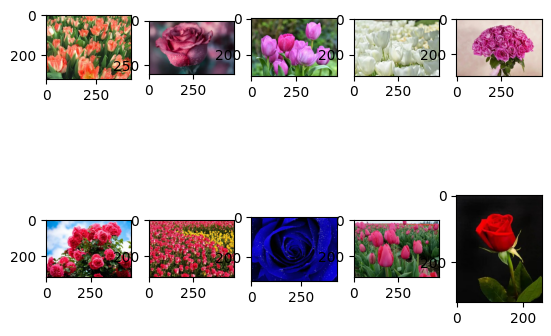

In [37]:
rand_list = np.random.randint(1, int(len(list_abs_path)*0.8),size=10)

fig = plt.figure()
i=1
for rand in rand_list:
    fig.add_subplot(2,5,i)
    image = Image.open(list_abs_path[rand])
    plt.imshow(image)
    i+=1

plt.show()

# Пункт 3

Модель сверточной нейронной сети для решения задачи классификации

In [38]:
class CNN(nn.Module):
    def __init__(self) -> None:
        super(CNN, self).__init__()

        self.conv_1 = nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2)
        self.conv_2 = nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2)
        self.conv_3 = nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.max_pool = nn.MaxPool2d(2)

        self.fc_1 = nn.Linear(576, 10)
        self.fc_2 = nn.Linear(10, 1)

    def forward(self, x: torch.tensor) -> torch.tensor:
        output = self.relu(self.conv_1(x))
        output = self.max_pool(output)
        output = self.relu(self.conv_2(output))
        output = self.max_pool(output)
        output = self.relu(self.conv_3(output))
        output = self.max_pool(output)

        output = nn.Flatten()(output)
        output = self.relu(self.fc_1(output))
        output = nn.Sigmoid()(self.fc_2(output))
        return output

# Пункт 4

Создание тесттового, тренировочного и валидного датасета из аннотаций

Перенесение обучения на GPU, предобработка данных

In [39]:

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

custom_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Resize(
                                                        (224, 224)),
                                                    torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

train_dataset = CustomImageDataset('train_anntotation.csv', custom_transforms)
test_dataset = CustomImageDataset('test_anntotation.csv', custom_transforms)
val_dataset = CustomImageDataset('val_anntotation.csv', custom_transforms)

print(len(train_dataset), len(test_dataset), len(val_dataset))

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)


cuda:0
1630 203 203


# Пункт 5 и 6

задание параметров оптимизатора

In [58]:
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()


цикл обучения

In [59]:
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))


Epoch : 1, train accuracy : 0.6321568627450981, train loss : 0.6447415947914124
Epoch : 1, val accuracy : 0.77, val loss : 0.5880942344665527
Epoch : 2, train accuracy : 0.7209803921568627, train loss : 0.548057496547699
Epoch : 2, val accuracy : 0.76, val loss : 0.569627046585083
Epoch : 3, train accuracy : 0.7533333333333333, train loss : 0.5100009441375732
Epoch : 3, val accuracy : 0.7055555555555555, val loss : 0.5288646817207336
Epoch : 4, train accuracy : 0.7886274509803921, train loss : 0.44513413310050964
Epoch : 4, val accuracy : 0.7022222222222222, val loss : 0.4855329990386963
Epoch : 5, train accuracy : 0.8141176470588236, train loss : 0.41304609179496765
Epoch : 5, val accuracy : 0.7222222222222222, val loss : 0.5000076293945312
Epoch : 6, train accuracy : 0.806078431372549, train loss : 0.4191093444824219
Epoch : 6, val accuracy : 0.7288888888888888, val loss : 0.4865165650844574
Epoch : 7, train accuracy : 0.8152941176470587, train loss : 0.41971421241760254
Epoch : 7, v

графики для значения функции потерь

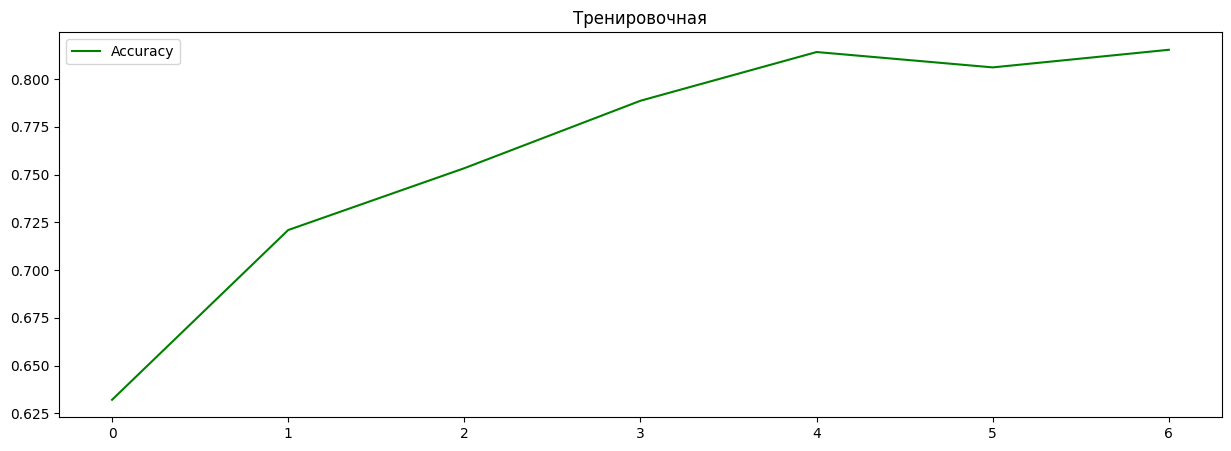

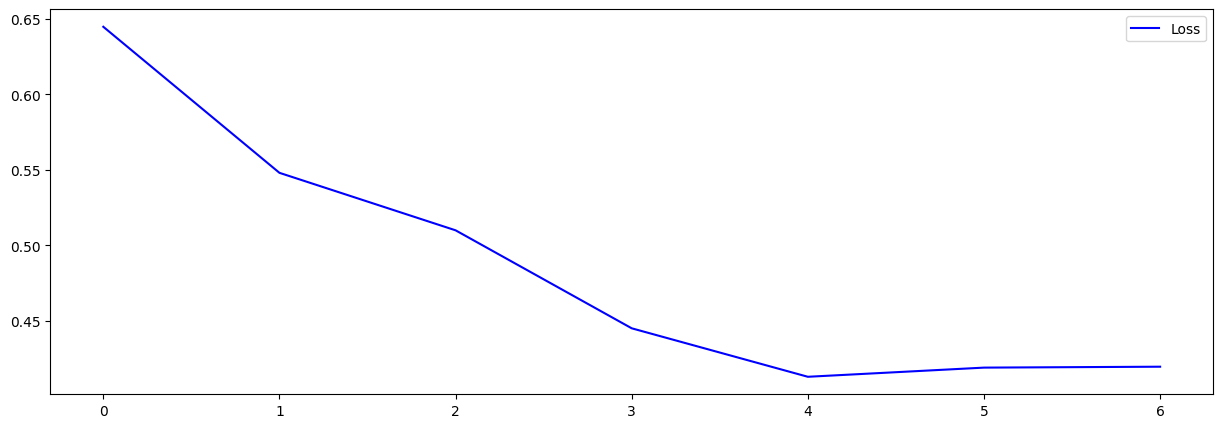

In [60]:
plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

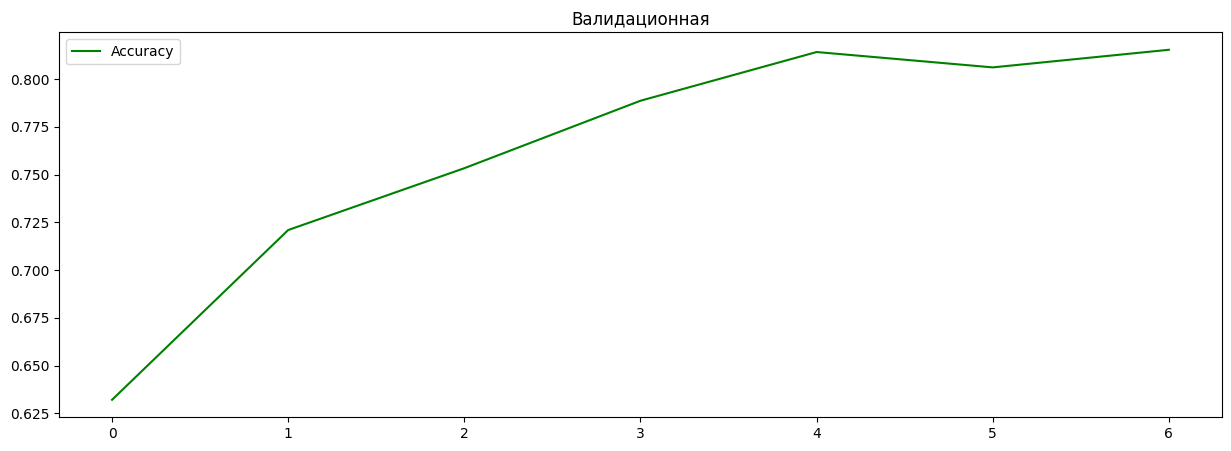

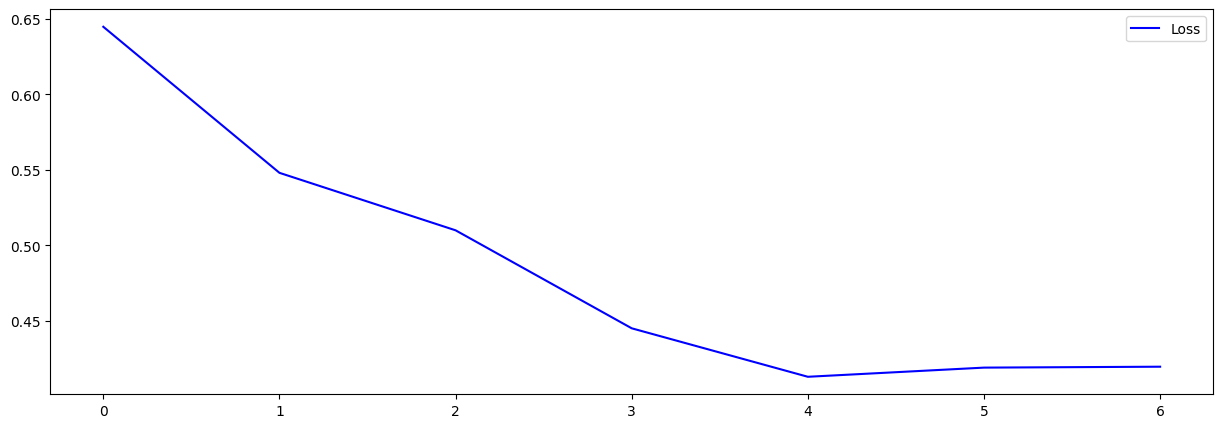

In [61]:
plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

# с другими параметрами

batch_size=10 lr=0.001

Epoch : 1, train accuracy : 0.5024539877300602, train loss : 0.6942194104194641
Epoch : 1, val accuracy : 0.49365079365079356, val loss : 0.6945197582244873
Epoch : 2, train accuracy : 0.5024539877300606, train loss : 0.6936770677566528
Epoch : 2, val accuracy : 0.49365079365079356, val loss : 0.6940664052963257
Epoch : 3, train accuracy : 0.5024539877300604, train loss : 0.6934829950332642
Epoch : 3, val accuracy : 0.49365079365079356, val loss : 0.6937809586524963
Epoch : 4, train accuracy : 0.5024539877300603, train loss : 0.6933630108833313
Epoch : 4, val accuracy : 0.49365079365079356, val loss : 0.6936721801757812
Epoch : 5, train accuracy : 0.5024539877300606, train loss : 0.6933003067970276
Epoch : 5, val accuracy : 0.49365079365079356, val loss : 0.693508505821228
Epoch : 6, train accuracy : 0.5024539877300604, train loss : 0.6932563185691833
Epoch : 6, val accuracy : 0.49365079365079356, val loss : 0.6934546828269958
Epoch : 7, train accuracy : 0.5024539877300604, train loss 

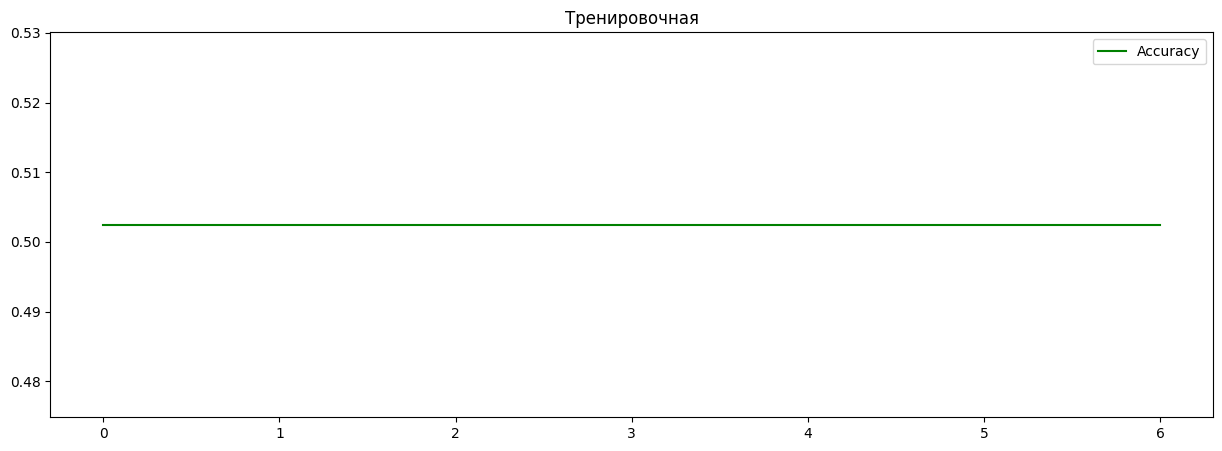

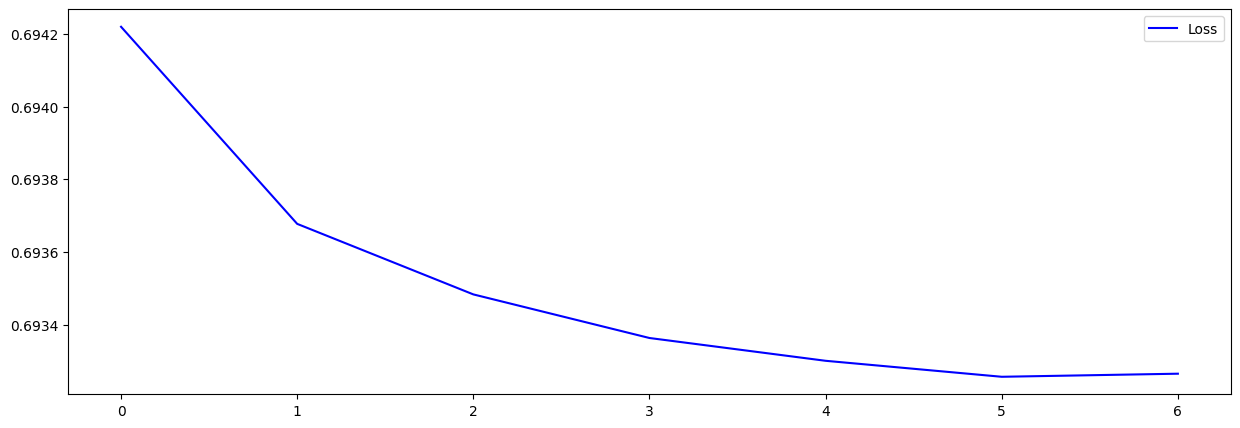

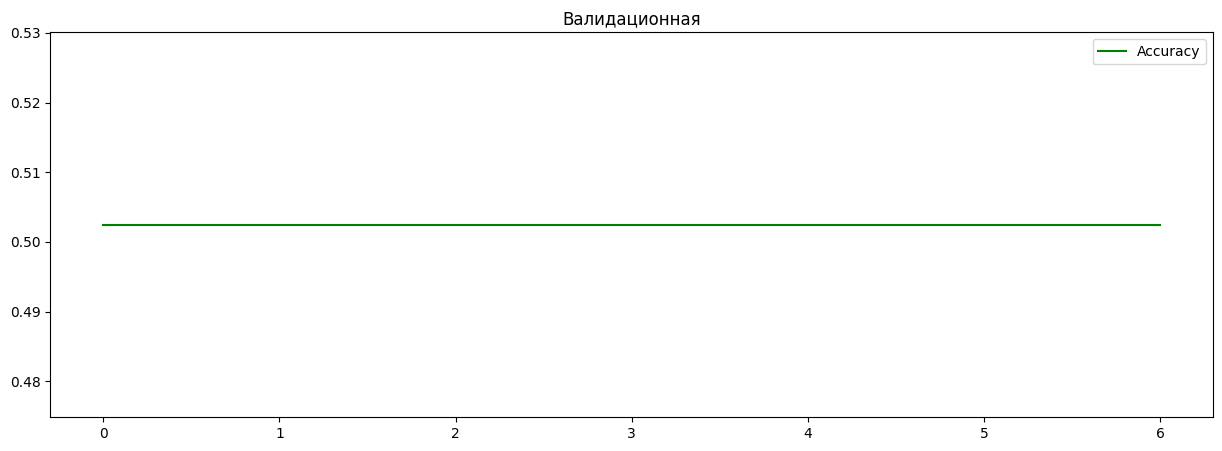

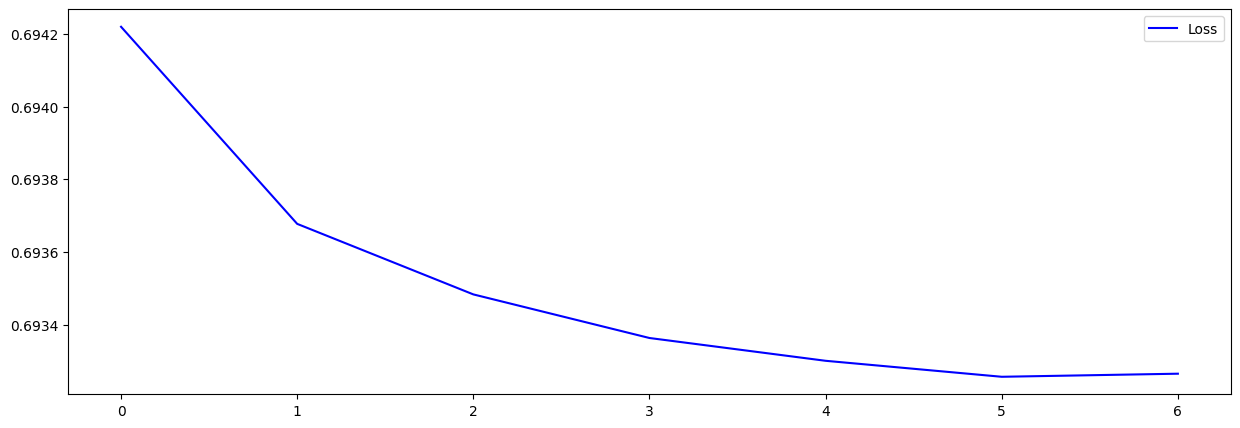

In [45]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=10 lr=0.1

Epoch : 1, train accuracy : 0.4999999999999991, train loss : 49.57515335083008
Epoch : 1, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 2, train accuracy : 0.5024539877300603, train loss : 49.75459671020508
Epoch : 2, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 3, train accuracy : 0.5024539877300606, train loss : 49.75462341308594
Epoch : 3, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 4, train accuracy : 0.5024539877300604, train loss : 49.754608154296875
Epoch : 4, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 5, train accuracy : 0.5024539877300604, train loss : 49.75459671020508
Epoch : 5, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 6, train accuracy : 0.5024539877300604, train loss : 49.75459671020508
Epoch : 6, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 7, train accuracy : 0.5024539877300603, train loss : 49.75460

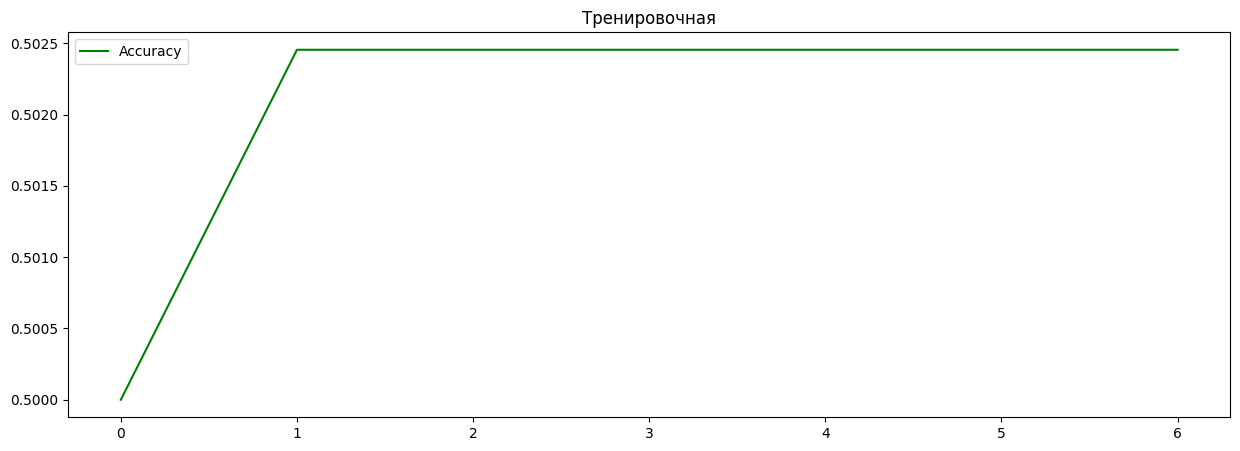

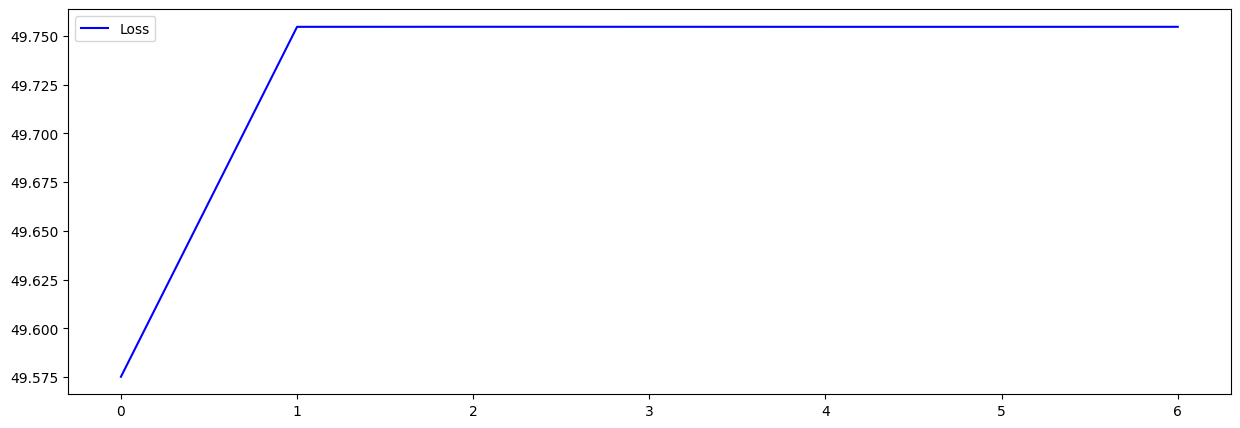

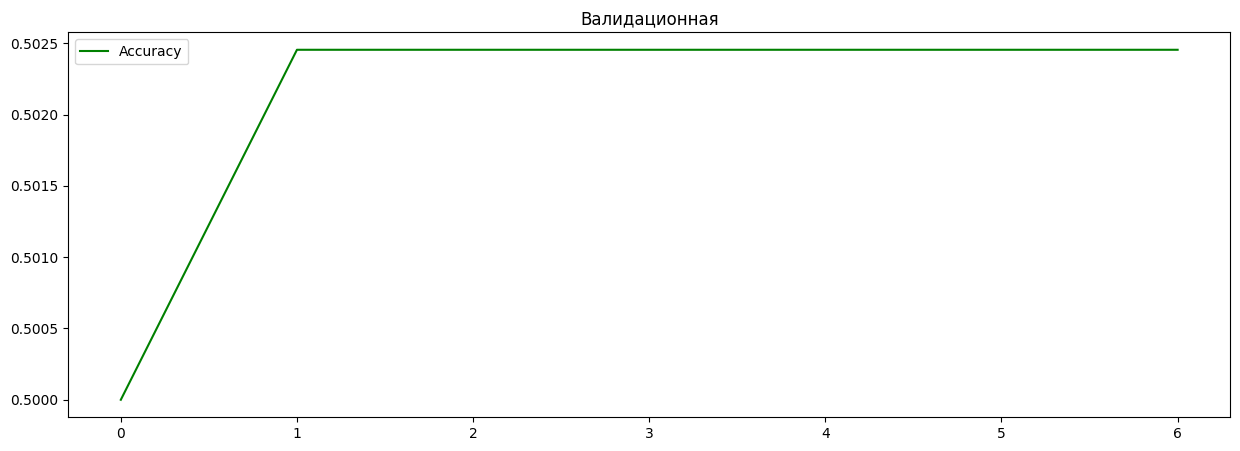

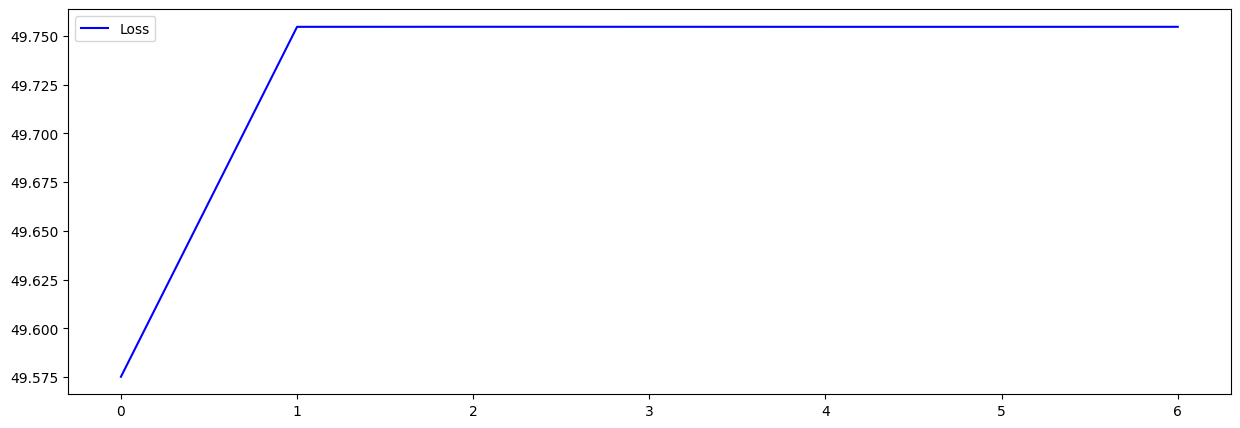

In [46]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.1)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=10 lr=1

Epoch : 1, train accuracy : 0.5018404907975452, train loss : 49.4521484375
Epoch : 1, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 2, train accuracy : 0.5024539877300604, train loss : 49.75461196899414
Epoch : 2, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 3, train accuracy : 0.5024539877300606, train loss : 49.75462341308594
Epoch : 3, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 4, train accuracy : 0.5024539877300603, train loss : 49.75459671020508
Epoch : 4, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 5, train accuracy : 0.5024539877300603, train loss : 49.75459289550781
Epoch : 5, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 6, train accuracy : 0.5024539877300602, train loss : 49.754615783691406
Epoch : 6, val accuracy : 0.49365079365079356, val loss : 50.63492202758789
Epoch : 7, train accuracy : 0.5024539877300603, train loss : 49.754596710

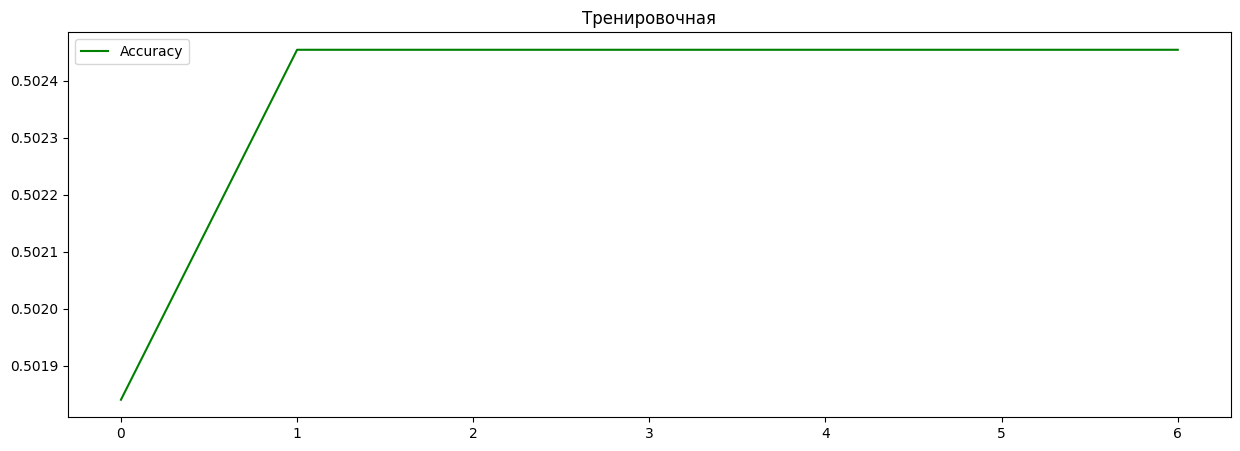

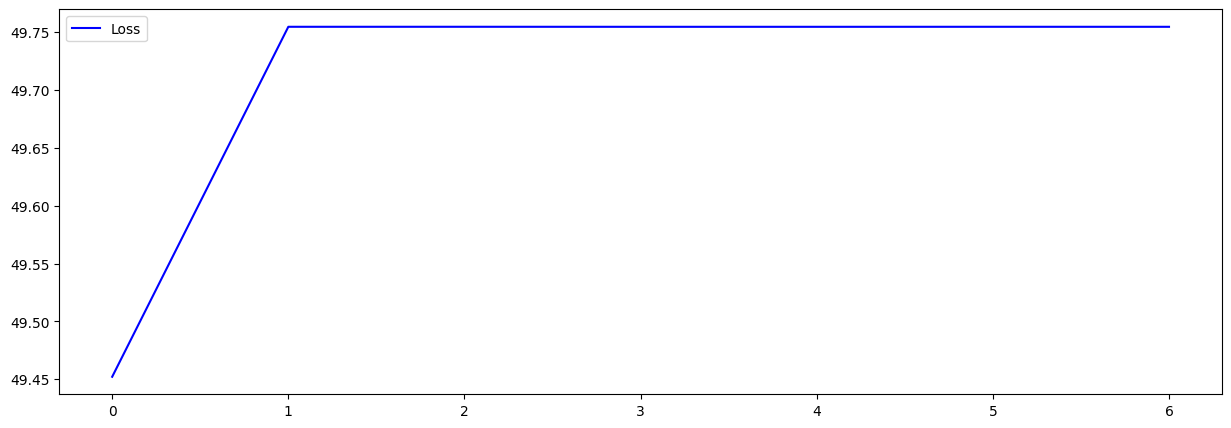

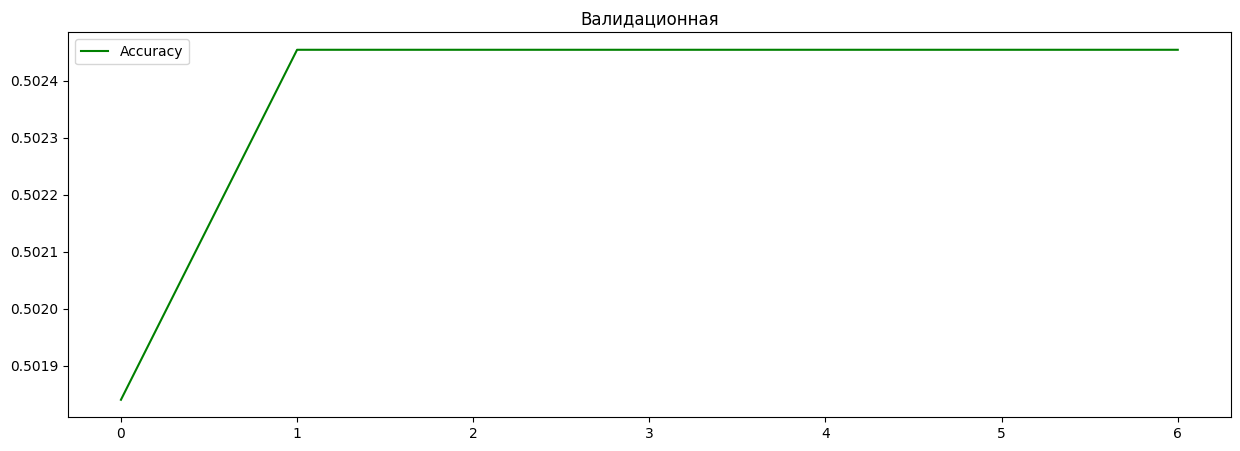

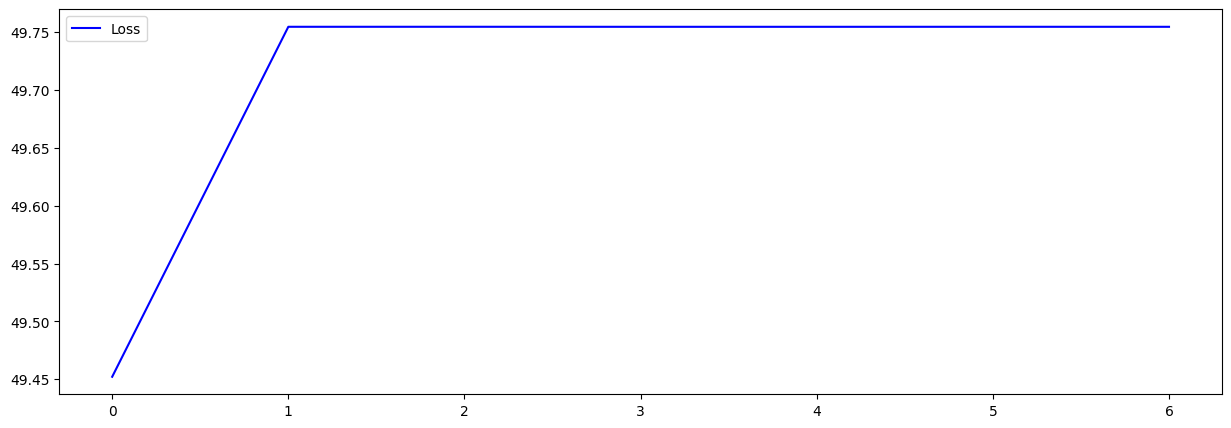

In [47]:
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=10, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=1 lr=0.001

Epoch : 1, train accuracy : 0.6999999999999965, train loss : 0.5675258636474609
Epoch : 1, val accuracy : 0.7487684729064031, val loss : 0.6392120122909546
Epoch : 2, train accuracy : 0.7840490797545973, train loss : 0.4697072505950928
Epoch : 2, val accuracy : 0.7438423645320189, val loss : 0.5216168165206909
Epoch : 3, train accuracy : 0.8073619631901799, train loss : 0.41944319009780884
Epoch : 3, val accuracy : 0.7044334975369451, val loss : 0.5837331414222717
Epoch : 4, train accuracy : 0.831288343558278, train loss : 0.38405290246009827
Epoch : 4, val accuracy : 0.8078817733990139, val loss : 0.4092888832092285
Epoch : 5, train accuracy : 0.8693251533742287, train loss : 0.3234604597091675
Epoch : 5, val accuracy : 0.8472906403940877, val loss : 0.34889137744903564
Epoch : 6, train accuracy : 0.8852760736196273, train loss : 0.2695806622505188
Epoch : 6, val accuracy : 0.8571428571428562, val loss : 0.37777015566825867
Epoch : 7, train accuracy : 0.90858895705521, train loss : 0.

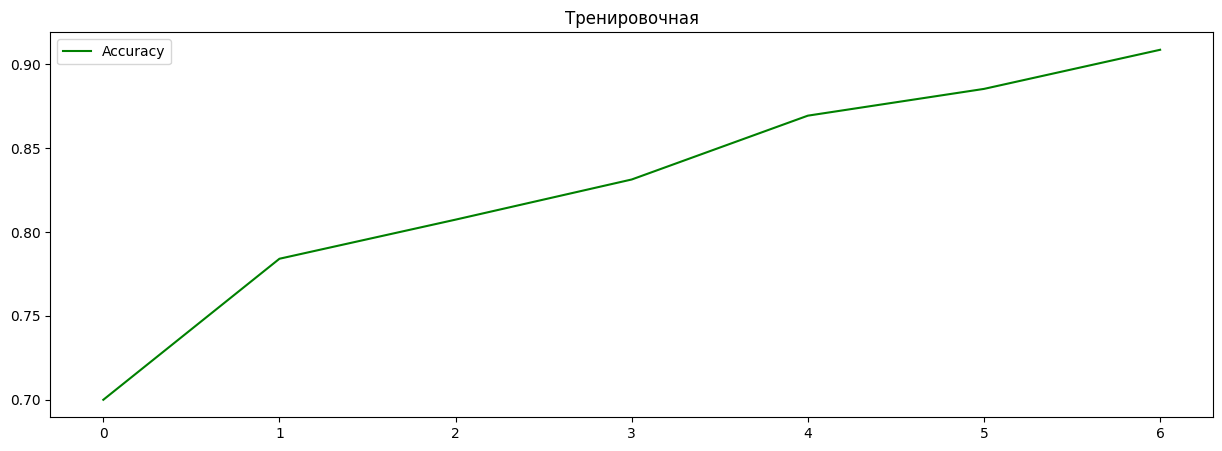

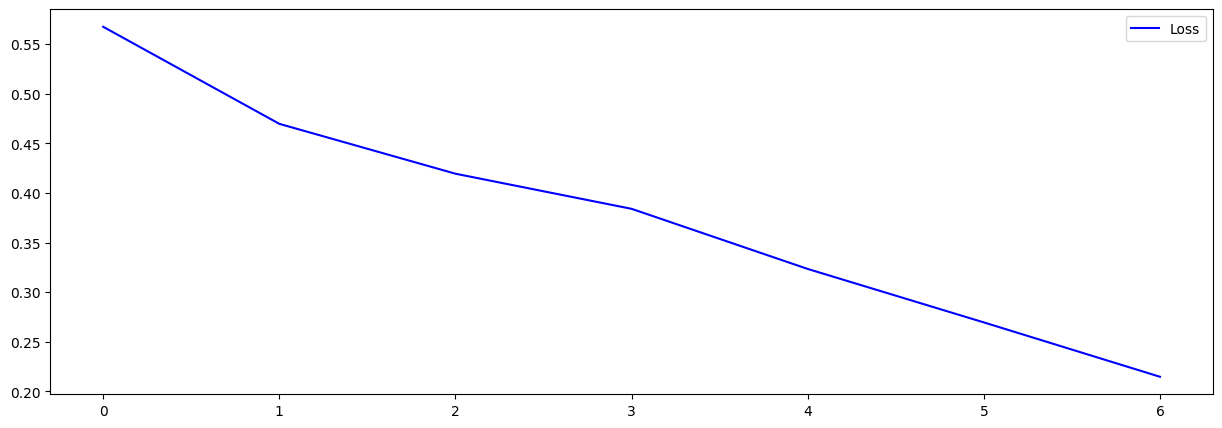

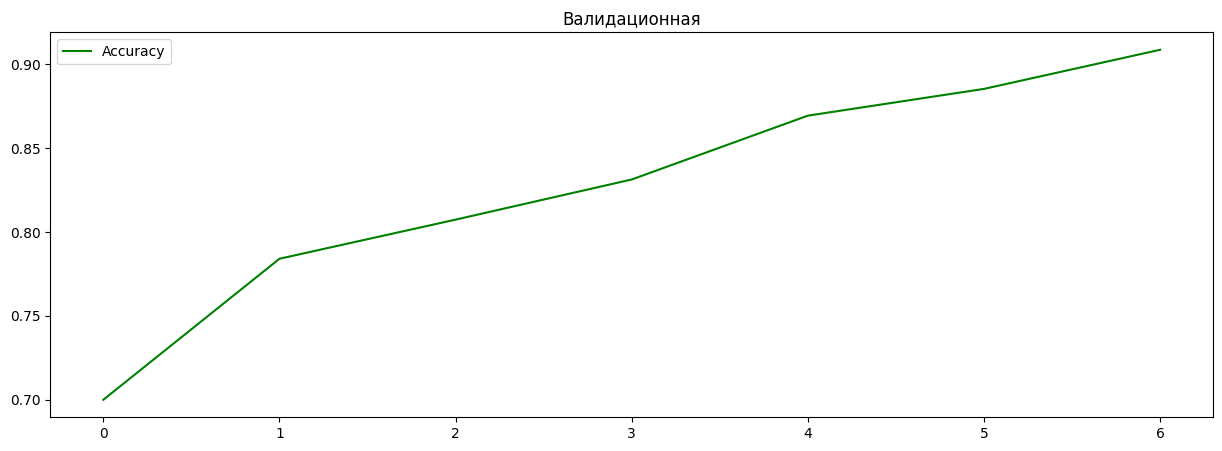

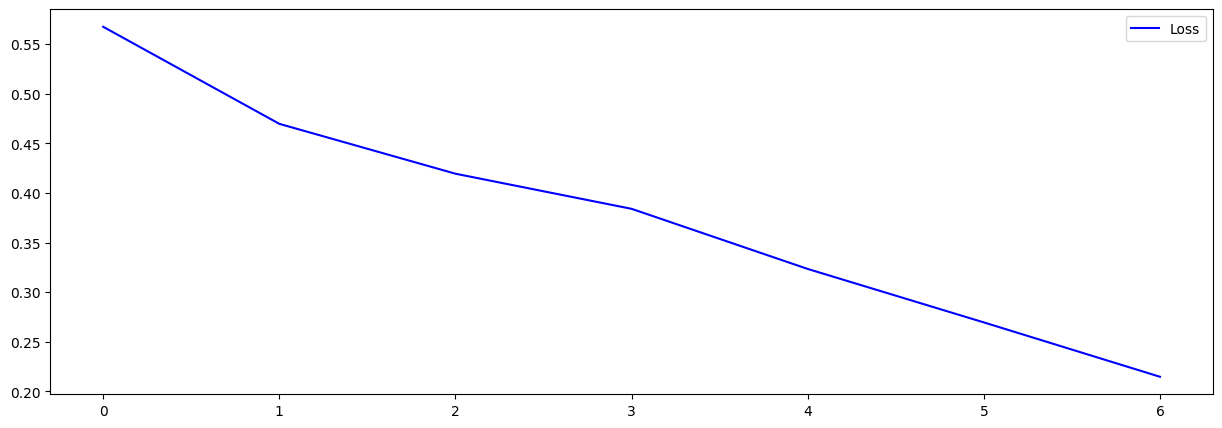

In [48]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=1 lr=0.1

Epoch : 1, train accuracy : 0.5018404907975437, train loss : 49.75468826293945
Epoch : 1, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 2, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 2, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 3, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 3, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 4, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 4, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 5, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 5, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 6, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 6, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 7, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epo

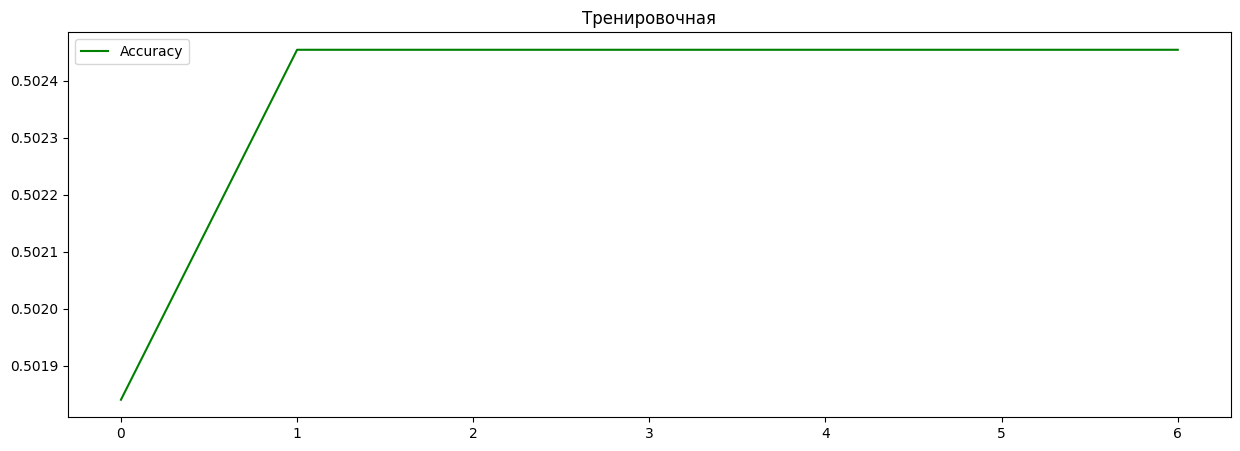

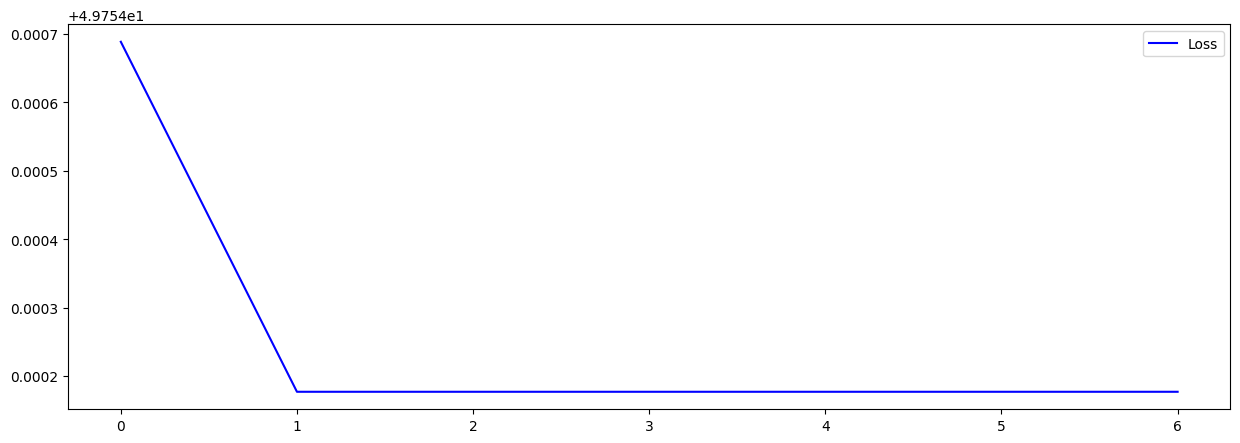

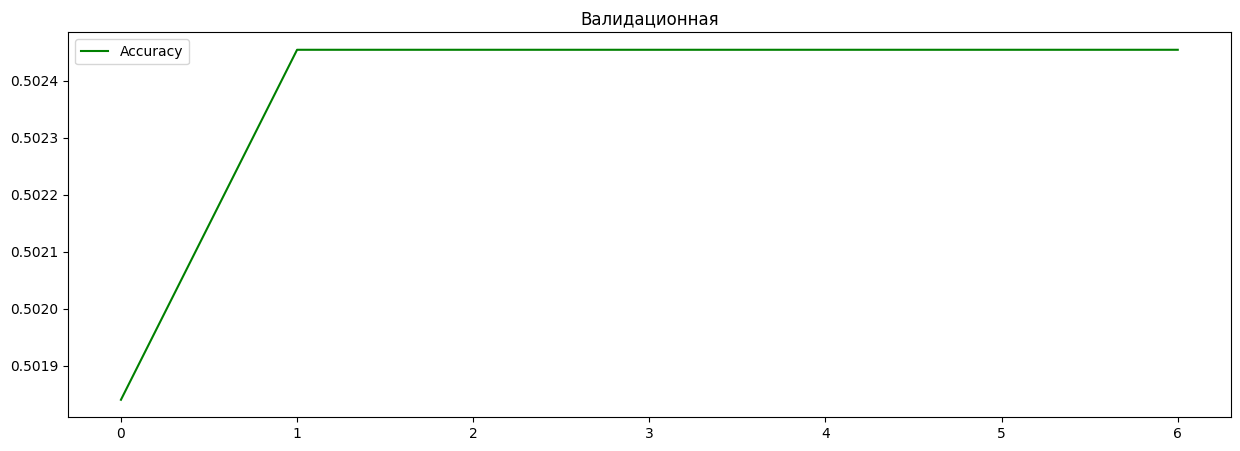

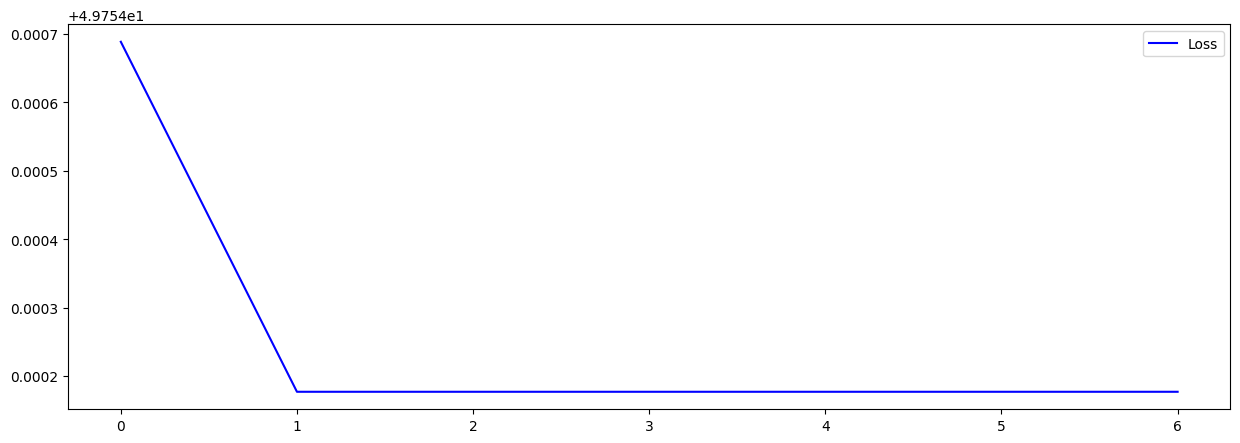

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.1)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=1 lr=1

Epoch : 1, train accuracy : 0.5018404907975437, train loss : 49.754642486572266
Epoch : 1, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 2, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 2, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 3, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 3, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 4, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 4, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 5, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 5, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 6, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Epoch : 6, val accuracy : 0.4876847290640389, val loss : 51.23153305053711
Epoch : 7, train accuracy : 0.502453987730059, train loss : 49.75417709350586
Ep

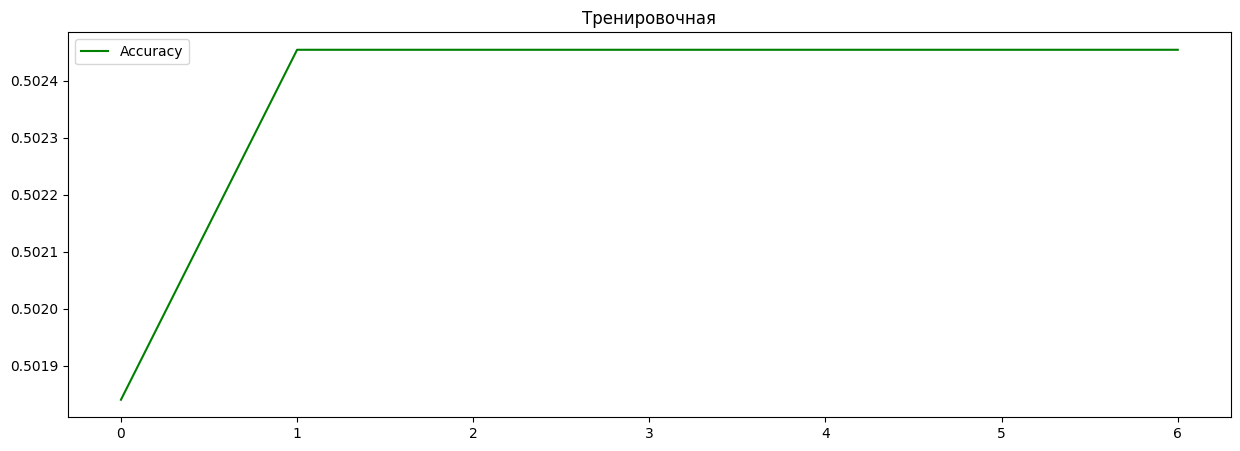

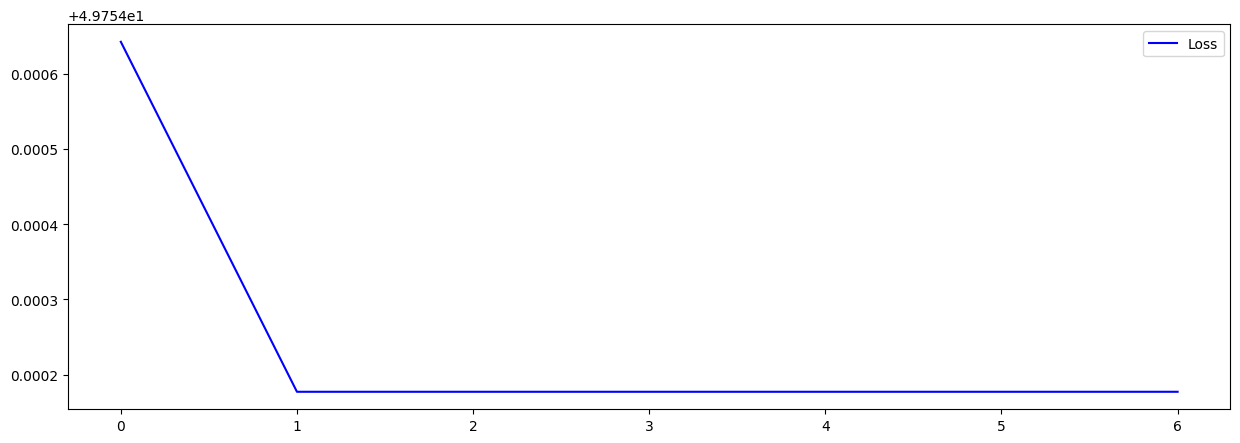

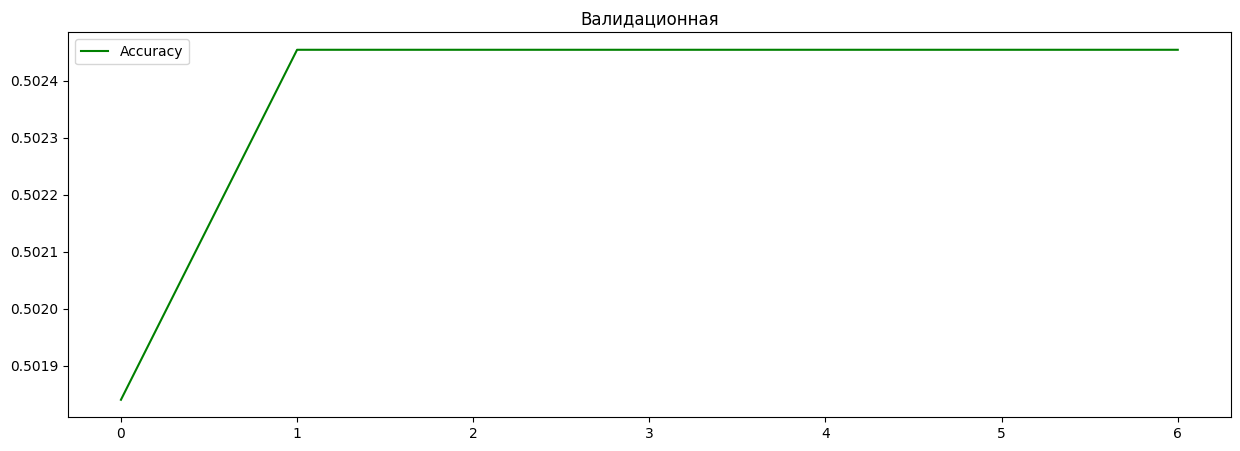

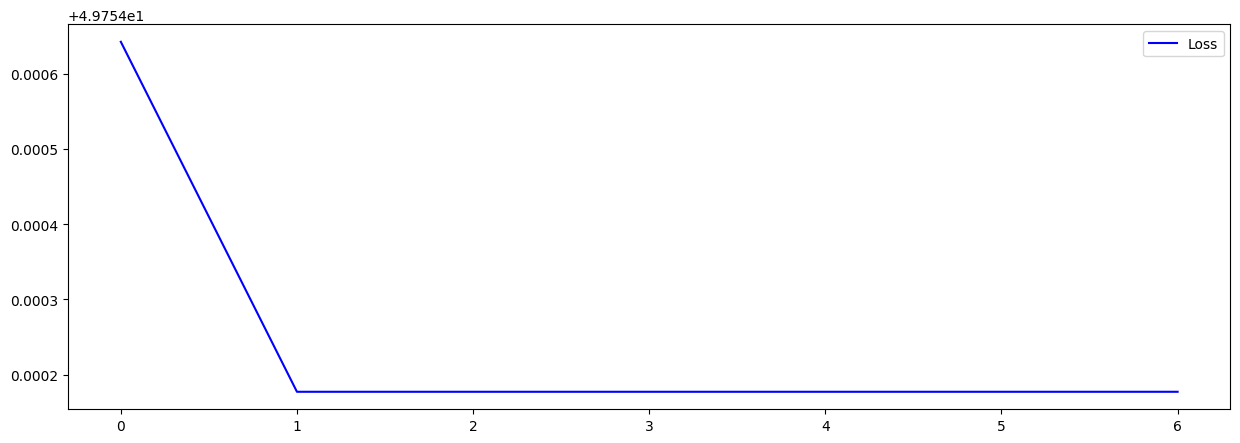

In [50]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=100 lr=0.001

Epoch : 1, train accuracy : 0.5852941176470589, train loss : 0.6733798980712891
Epoch : 1, val accuracy : 0.6488888888888888, val loss : 0.6457862257957458
Epoch : 2, train accuracy : 0.738235294117647, train loss : 0.547822117805481
Epoch : 2, val accuracy : 0.6955555555555556, val loss : 0.5740031003952026
Epoch : 3, train accuracy : 0.7913725490196079, train loss : 0.454643189907074
Epoch : 3, val accuracy : 0.7388888888888889, val loss : 0.5378113985061646
Epoch : 4, train accuracy : 0.8068627450980391, train loss : 0.4319929778575897
Epoch : 4, val accuracy : 0.7188888888888889, val loss : 0.5327025651931763
Epoch : 5, train accuracy : 0.8347058823529412, train loss : 0.3897296190261841
Epoch : 5, val accuracy : 0.7222222222222222, val loss : 0.5293822288513184
Epoch : 6, train accuracy : 0.8421568627450982, train loss : 0.3704092800617218
Epoch : 6, val accuracy : 0.7455555555555556, val loss : 0.5307359099388123
Epoch : 7, train accuracy : 0.8550980392156864, train loss : 0.3600

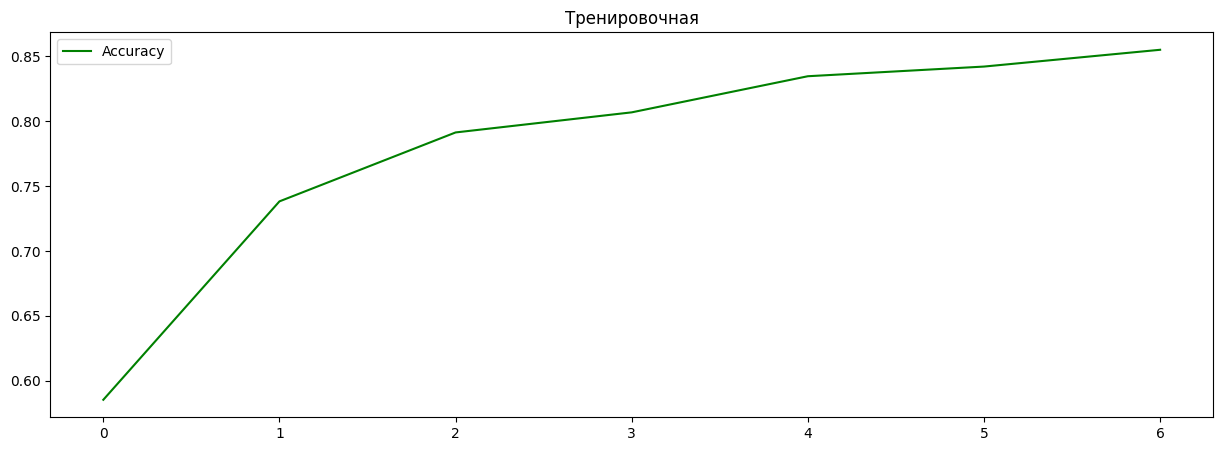

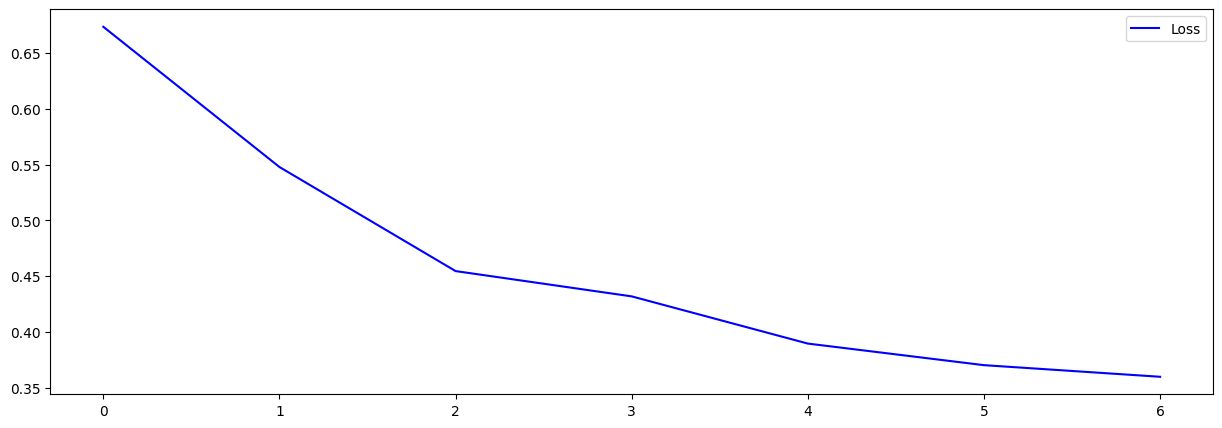

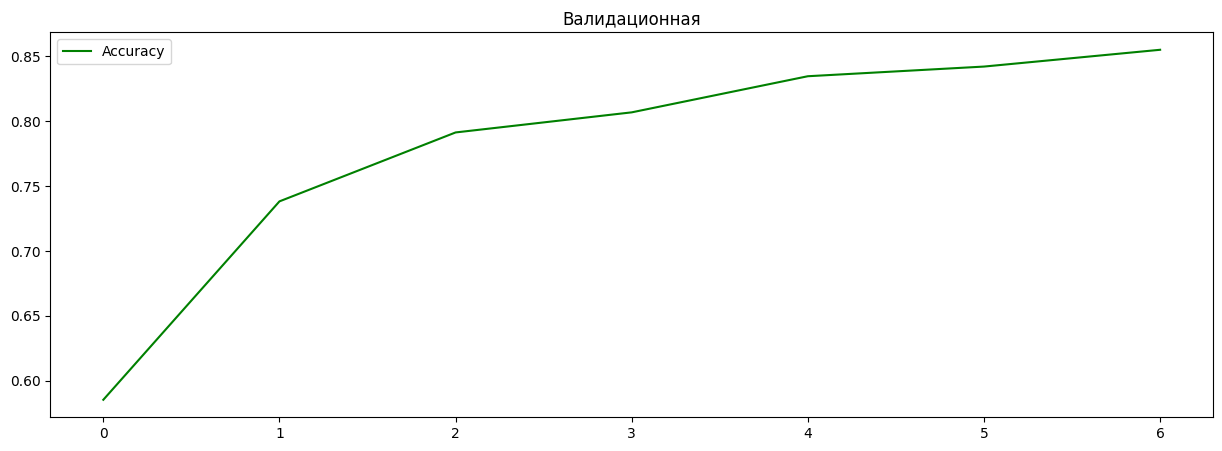

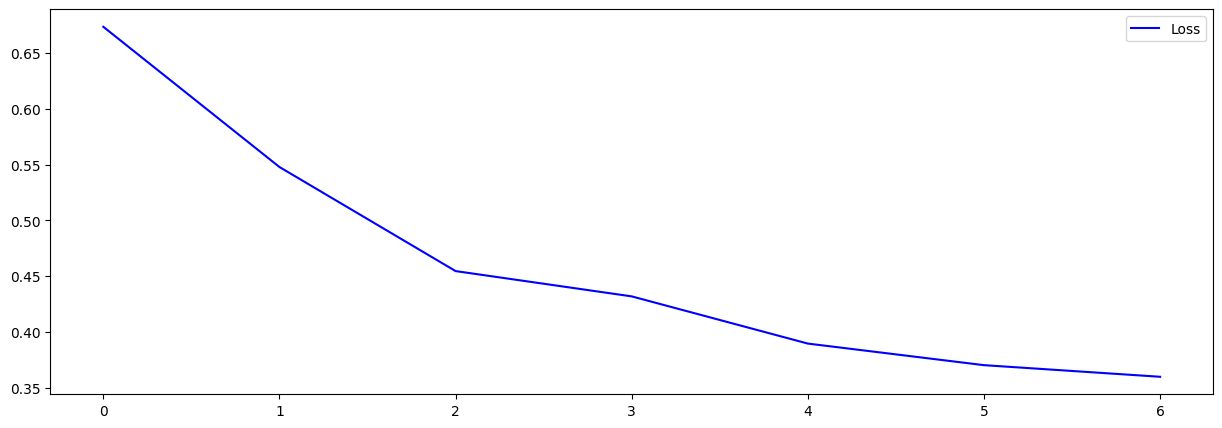

In [51]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=100 lr=0.1

Epoch : 1, train accuracy : 0.5001960784313726, train loss : 47.13883590698242
Epoch : 1, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 2, train accuracy : 0.4949019607843137, train loss : 50.50980758666992
Epoch : 2, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 3, train accuracy : 0.5031372549019608, train loss : 49.686275482177734
Epoch : 3, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 4, train accuracy : 0.5031372549019608, train loss : 49.68627166748047
Epoch : 4, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 5, train accuracy : 0.49490196078431375, train loss : 50.50980758666992
Epoch : 5, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 6, train accuracy : 0.4962745098039217, train loss : 50.37255096435547
Epoch : 6, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 7, train accuracy : 0.49490196078431375, train loss : 50.509

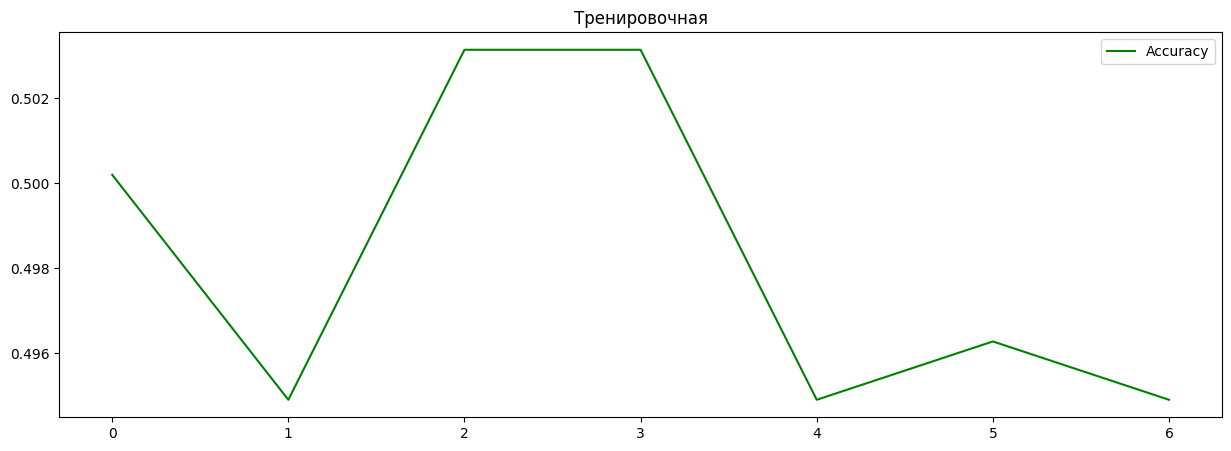

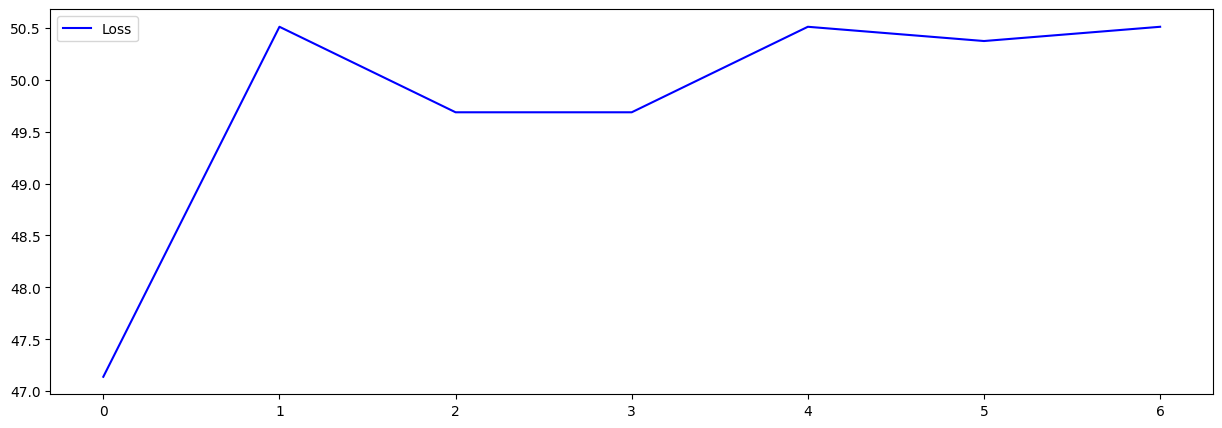

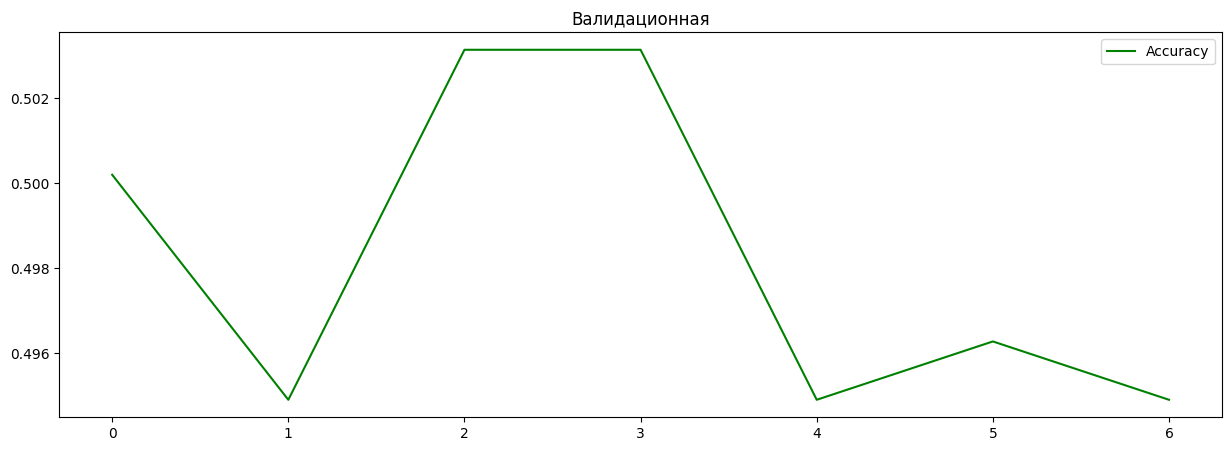

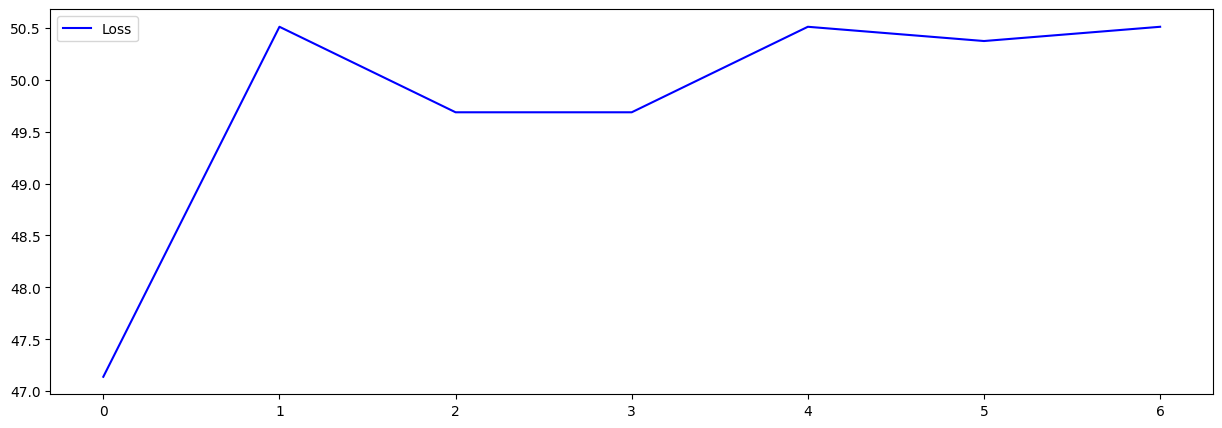

In [52]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.1)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

batch_size=100 lr=1

Epoch : 1, train accuracy : 0.492156862745098, train loss : 47.884029388427734
Epoch : 1, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 2, train accuracy : 0.4949019607843137, train loss : 50.50979995727539
Epoch : 2, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 3, train accuracy : 0.49764705882352944, train loss : 50.23529815673828
Epoch : 3, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 4, train accuracy : 0.49764705882352933, train loss : 50.235294342041016
Epoch : 4, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 5, train accuracy : 0.49901960784313726, train loss : 50.09803771972656
Epoch : 5, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 6, train accuracy : 0.4990196078431373, train loss : 50.09804153442383
Epoch : 6, val accuracy : 0.45444444444444443, val loss : 54.55556106567383
Epoch : 7, train accuracy : 0.49490196078431375, train loss : 50.5

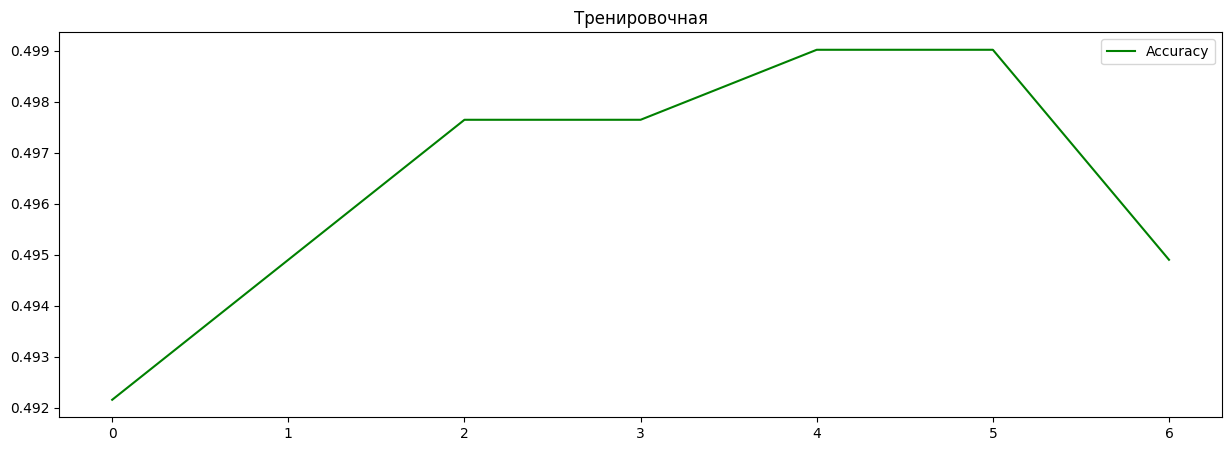

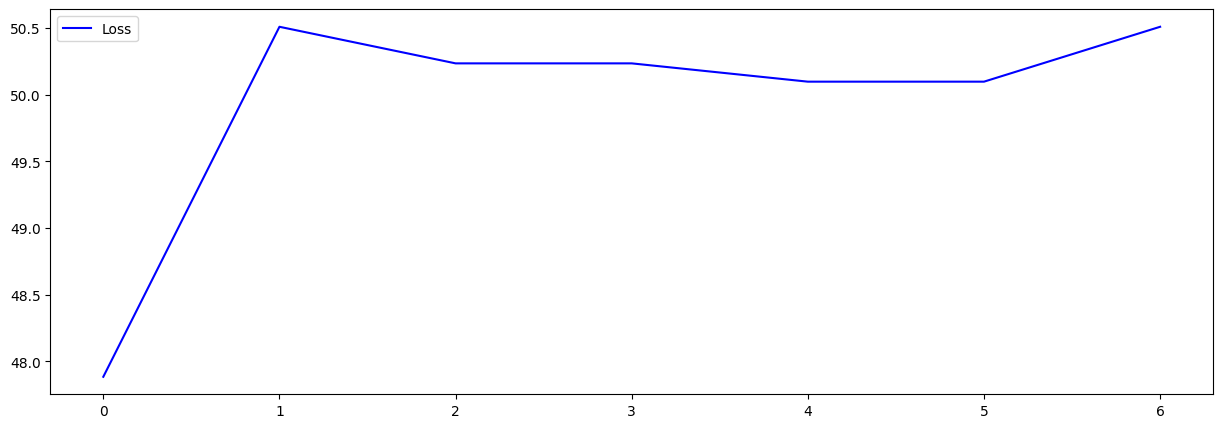

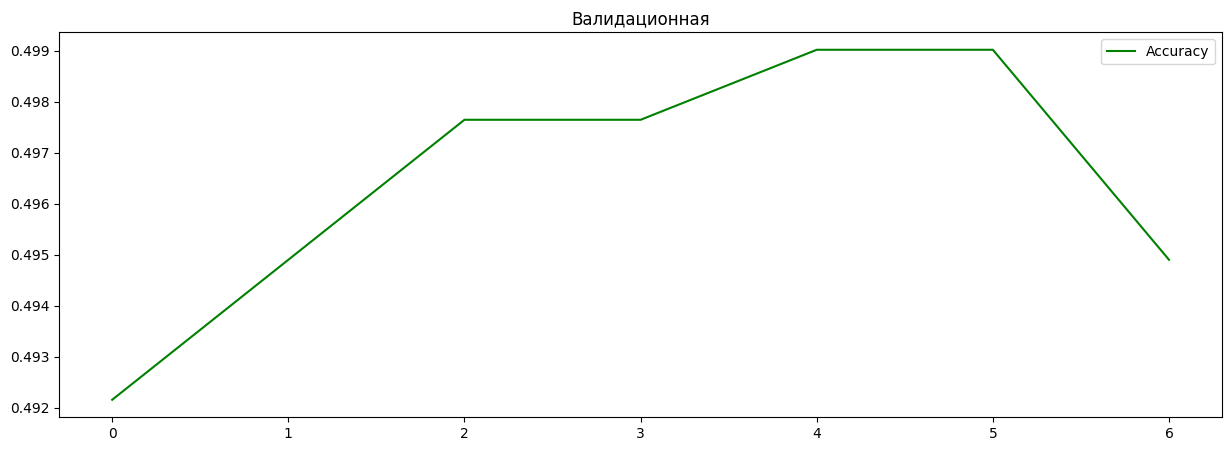

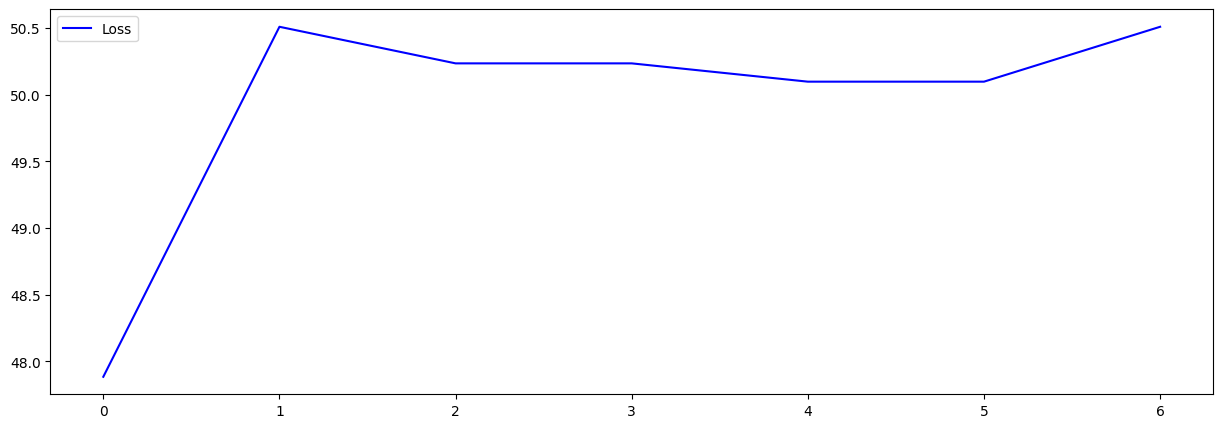

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=100, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=1)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

Epoch : 1, train accuracy : 0.7003676470588214, train loss : 0.550588846206665
Epoch : 1, val accuracy : 0.7287581699346403, val loss : 0.5472637414932251
Epoch : 2, train accuracy : 0.8069852941176446, train loss : 0.42887797951698303
Epoch : 2, val accuracy : 0.7140522875816991, val loss : 0.613743782043457
Epoch : 3, train accuracy : 0.8388480392156837, train loss : 0.3754960000514984
Epoch : 3, val accuracy : 0.7941176470588235, val loss : 0.461046427488327
Epoch : 4, train accuracy : 0.8547794117647033, train loss : 0.3409106433391571
Epoch : 4, val accuracy : 0.8333333333333336, val loss : 0.3855336904525757
Epoch : 5, train accuracy : 0.8872549019607816, train loss : 0.26857051253318787
Epoch : 5, val accuracy : 0.8480392156862748, val loss : 0.356379896402359
Epoch : 6, train accuracy : 0.899509803921566, train loss : 0.24244990944862366
Epoch : 6, val accuracy : 0.8529411764705884, val loss : 0.34893566370010376
Epoch : 7, train accuracy : 0.9209558823529383, train loss : 0.20

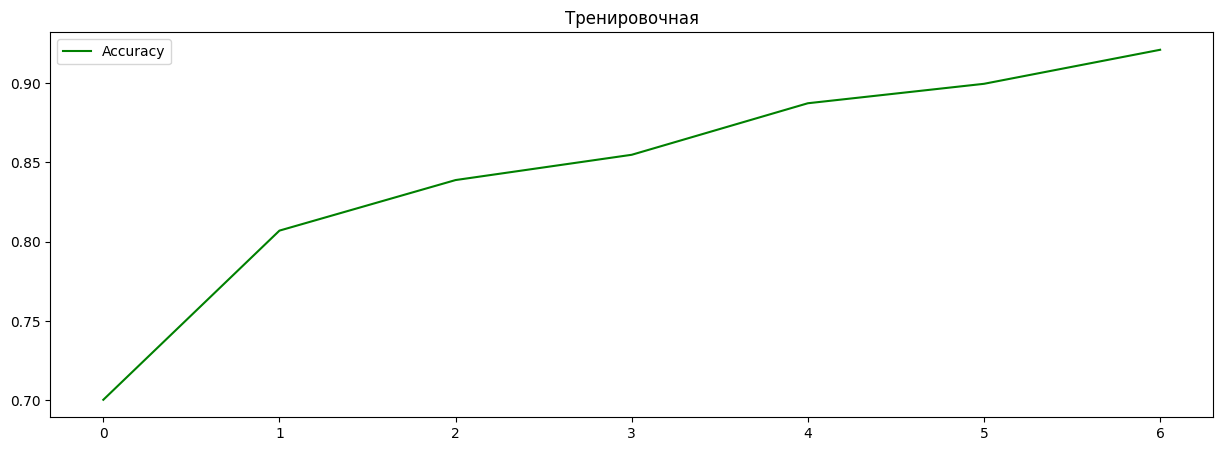

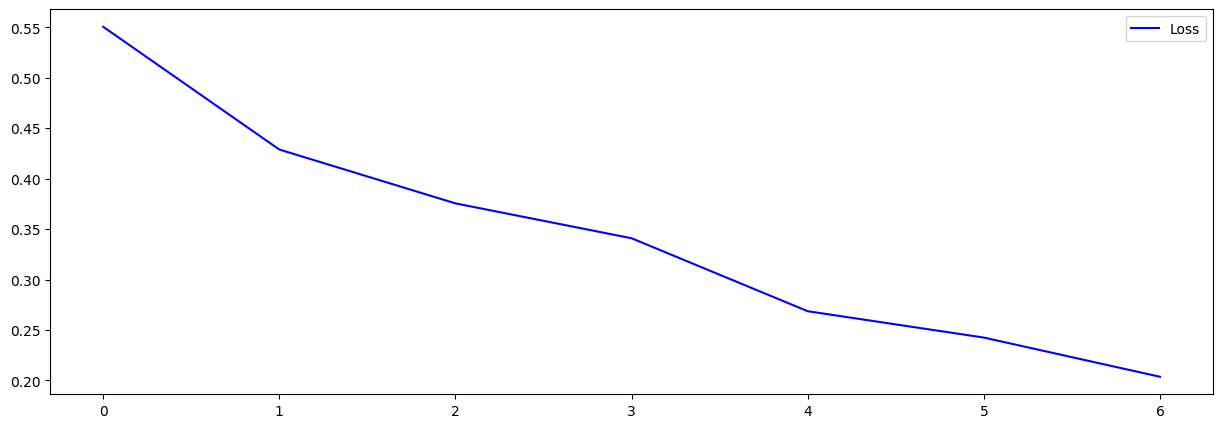

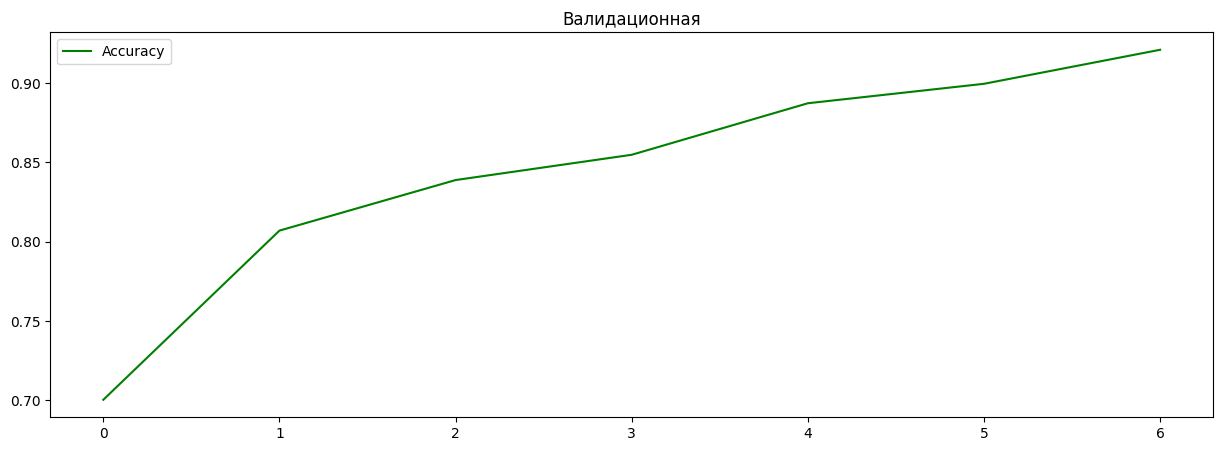

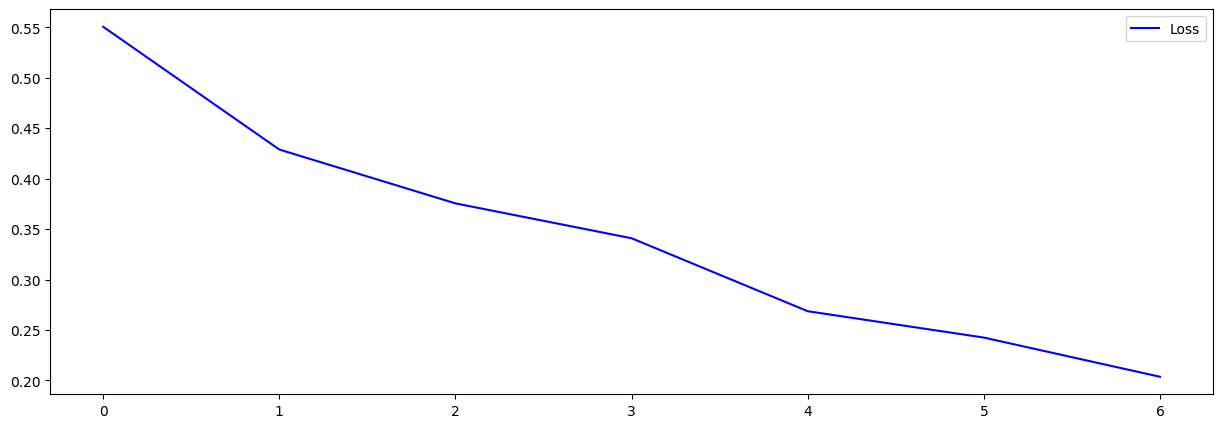

In [75]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)
model = CNN().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=0.001)
criterion = nn.BCELoss()
epochs = 7
accuracy_values = []
loss_values = []
accuracy_val_values = []
loss_val_values = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    epoch_accuracy = 0
    epoch_val_accuracy = 0
    epoch_val_loss = 0

    for data, label in train_dataloader:
        
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label.unsqueeze(dim=1).to(torch.float))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_accuracy += acc / len(train_dataloader)
        epoch_loss += loss / len(train_dataloader)

    accuracy_values.append(epoch_accuracy)
    loss_values.append(epoch_loss)
    print('Epoch : {}, train accuracy : {}, train loss : {}'.format(
        epoch + 1, epoch_accuracy, epoch_loss))

    model.eval()
    for data, label in val_dataloader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss_val = criterion(output, label.unsqueeze(dim=1).to(torch.float))
        acc_val = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(
            label[j]) else 0 for j in range(label.shape[0])])).mean()
        epoch_val_accuracy += acc_val / len(val_dataloader)
        epoch_val_loss += loss_val / len(val_dataloader)

    accuracy_val_values.append(epoch_val_accuracy)
    loss_val_values.append(epoch_val_loss)

    print('Epoch : {}, val accuracy : {}, val loss : {}'.format(
        epoch + 1, epoch_val_accuracy, epoch_val_loss))

plt.figure(1, figsize=(15, 5))
plt.title(
        'Тренировочная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

plt.figure(1, figsize=(15, 5))
plt.title(
        'Валидационная')
plt.plot(range(len(accuracy_values)), accuracy_values, color="green")
plt.legend(["Accuracy"])
plt.show()
plt.figure(1, figsize=(15, 5))
plt.plot(range(len(loss_values)), [
        float(value.detach()) for value in loss_values], color="blue")
plt.legend(["Loss"])
plt.show()

# Пункт 9

сохраняем модель

In [76]:
torch.save(model.state_dict(), os.path.join(r"C:\Users\dstep\OneDrive", "weight.pt"))

# Пункт 10

загрузка модели

In [77]:
model = CNN()
model.load_state_dict(torch.load(os.path.join(r"C:\Users\dstep\OneDrive", "weight.pt")))


<All keys matched successfully>

проверка модели

In [78]:
model.eval()

print(device)

test_loss = 0
test_accuracy = 0
    
for data, label in test_dataloader:
    data = data
    label = label

    output = model(data)
    
    acc = np.array(([1 if (1 if output[j][0].detach() >= 0.5 else 0) == int(label[j]) else 0 for j in range(3)])).mean()
    test_accuracy += acc / len(test_dataloader)
    test_loss += float(loss.detach()) / len(test_dataloader)
    
print(test_loss, test_accuracy)

cuda:0
0.009334996342658991 0.8758169934640522


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


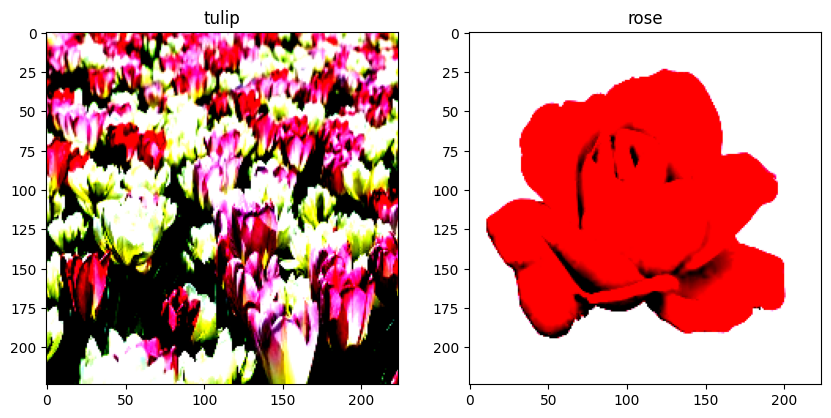

In [85]:
plt.figure(figsize=(10, 5))

for i in range(2):
  index = random.randint(0, 200)
  plt.subplot(1, 2, i + 1)
  plt.title("rose" if (1 if  model(test_dataset[index][0].unsqueeze(dim=0))[0] >= 0.5 else 0) == 0 else "tulip")
  plt.imshow(test_dataset[index][0].permute(1, 2, 0).numpy())